In [1]:
import pandas as pd
import numpy as np
import seaborn as sn

from collections import defaultdict
from sklearn.model_selection import train_test_split # data split
from sklearn import metrics
from sklearn.linear_model import LinearRegression # OLS algorithm
from sklearn.linear_model import Ridge # Ridge algorithm
from sklearn.linear_model import Lasso # Lasso algorithm
from sklearn.linear_model import BayesianRidge # Bayesian algorithm
from sklearn.linear_model import ElasticNet # ElasticNet algorithm
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import explained_variance_score as evs # evaluation metric
from sklearn.metrics import r2_score as r2 # evaluation metric
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score
from sklearn import preprocessing
import joblib
import folium
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
x_columns=['WindSustained', 'GustSustained','FPI', 'closeToWindThreshold', 'closeToGustThreshold', 'eFPI', 'eThres']

## Read data for Training

In [5]:
fire_df

,Circuit,WindSustained,GustSustained,Thresholds,FPI,Reasons,Month,pspsActivated
0,BLACKHILLS,12.2,18.60,31/46,3.72,NaN,OCT,0
1,GNATCATCHER,9.1,21.00,31/46,4.20,NaN,OCT,0
2,ENERGY,11.9,20.90,31/46,4.18,NaN,OCT,0
3,ECHO,26.0,43.30,31/46,14.36,High Wind Trend - Exceeded FPI,DEC,1
4,LARCH,41.2,56.30,31/46,12.50,Exceeded Threshold - Exceeded FPI,JAN,1
...,...,...,...,...,...,...,...,...
1143,OAK KNOLL,10.2,15.00,31/46,3.00,NaN,DEC,0
1144,GRAPEVINE,8.9,22.00,31/46,4.40,NaN,NOV,0
1145,ACOSTA,36.1,64.52,31/46,12.56,Exceeded Threshold - High Wind Trend - Exceede...,OCT,1
1146,WOBEGONE,25.1,37.00,28/40,12.02,High Wind Trend - Exceeded FPI,NOV,1


In [4]:
fire_df = pd.read_csv("CSV/psps_data.csv")
fire_df.head()

,Circuit,WindSustained,GustSustained,Thresholds,FPI,Reasons,Month,pspsActivated
0,BLACKHILLS,12.2,18.6,31/46,3.72,NaN,OCT,0
1,GNATCATCHER,9.1,21.0,31/46,4.20,NaN,OCT,0
2,ENERGY,11.9,20.9,31/46,4.18,NaN,OCT,0
3,ECHO,26.0,43.3,31/46,14.36,High Wind Trend - Exceeded FPI,DEC,1
4,LARCH,41.2,56.3,31/46,12.50,Exceeded Threshold - Exceeded FPI,JAN,1


## Prepare dataset for training

In [14]:
data = fire_df.copy()
data[["WindThreshold", "GustTheshold"]] = data.Thresholds.str.split('/',expand=True)
data["WindThreshold"] = data["WindThreshold"].astype(float)
data["GustTheshold"] = data["GustTheshold"].astype(float)
data["closeToWindThreshold"] = round((data["WindSustained"] * 100)/data["WindThreshold"].astype(float), 2)
data["closeToGustThreshold"] = round((data["GustSustained"] * 100)/data["GustTheshold"].astype(float), 2)
data["eFPI"] =  data["FPI"].apply(lambda x: round(x/12,2))
data["eThres"] = round(data["WindSustained"] / data["WindThreshold"],2)
data["eThres"] = np.where(round(data["GustSustained"] / data["GustTheshold"], 2) > data["eThres"],round(data["GustSustained"] / data["GustTheshold"], 2) , data["eThres"])
data

,Circuit,WindSustained,GustSustained,Thresholds,FPI,Reasons,Month,pspsActivated,WindThreshold,GustTheshold,closeToWindThreshold,closeToGustThreshold,eFPI,eThres
0,BLACKHILLS,12.2,18.60,31/46,3.72,NaN,OCT,0,31.0,46.0,39.35,40.43,0.31,0.40
1,GNATCATCHER,9.1,21.00,31/46,4.20,NaN,OCT,0,31.0,46.0,29.35,45.65,0.35,0.46
2,ENERGY,11.9,20.90,31/46,4.18,NaN,OCT,0,31.0,46.0,38.39,45.43,0.35,0.45
3,ECHO,26.0,43.30,31/46,14.36,High Wind Trend - Exceeded FPI,DEC,1,31.0,46.0,83.87,94.13,1.20,0.94
4,LARCH,41.2,56.30,31/46,12.50,Exceeded Threshold - Exceeded FPI,JAN,1,31.0,46.0,132.90,122.39,1.04,1.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1143,OAK KNOLL,10.2,15.00,31/46,3.00,NaN,DEC,0,31.0,46.0,32.90,32.61,0.25,0.33
1144,GRAPEVINE,8.9,22.00,31/46,4.40,NaN,NOV,0,31.0,46.0,28.71,47.83,0.37,0.48
1145,ACOSTA,36.1,64.52,31/46,12.56,Exceeded Threshold - High Wind Trend - Exceede...,OCT,1,31.0,46.0,116.45,140.26,1.05,1.40
1146,WOBEGONE,25.1,37.00,28/40,12.02,High Wind Trend - Exceeded FPI,NOV,1,28.0,40.0,89.64,92.50,1.00,0.92


In [36]:
def prepare_test_data(data):
    data[["WindThreshold", "GustTheshold"]] = data.Thresholds.str.split('/',expand=True)
    data["WindThreshold"] = data["WindThreshold"].astype(float)
    data["GustTheshold"] = data["GustTheshold"].astype(float)
    data["closeToWindThreshold"] = round((data["WindSustained"] * 100)/data["WindThreshold"].astype(float), 2)
    data["closeToGustThreshold"] = round((data["GustSustained"] * 100)/data["GustTheshold"].astype(float), 2)
    
    data["eFPI"] =  data["FPI"].apply(lambda x: round(x/12,2))
    data["eThres"] = round(data["WindSustained"] / data["WindThreshold"],2)
    data["eThres"] = np.where(round(data["GustSustained"] / data["GustTheshold"], 2) > data["eThres"], 
                              round(data["GustSustained"] / data["GustTheshold"], 2) , data["eThres"])


    data.drop(["Thresholds"], axis=1, inplace=True)
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.fillna(0,inplace=True)
    return data

# Correlation

In [42]:
fire_df_prep = prepare_test_data(fire_df)    
fire_df_prep.corr()

,WindSustained,GustSustained,FPI,pspsActivated,WindThreshold,GustTheshold,closeToWindThreshold,closeToGustThreshold,eFPI,eThres
WindSustained,1.000000,0.817032,0.714158,0.753858,0.087376,0.080376,0.992861,0.807421,0.714290,0.923930
GustSustained,0.817032,1.000000,0.882609,0.916193,0.073059,0.079335,0.812686,0.991926,0.882648,0.911768
FPI,0.714158,0.882609,1.000000,0.971728,0.018532,0.023416,0.717369,0.882958,0.999975,0.813367
pspsActivated,0.753858,0.916193,0.971728,1.000000,0.001583,0.001581,0.760338,0.920786,0.971734,0.850049
WindThreshold,0.087376,0.073059,0.018532,0.001583,1.000000,0.852874,-0.022175,-0.026039,0.018484,-0.026645
GustTheshold,0.080376,0.079335,0.023416,0.001581,0.852874,1.000000,-0.014418,-0.038287,0.023688,-0.031559
closeToWindThreshold,0.992861,0.812686,0.717369,0.760338,-0.022175,-0.014418,1.000000,0.815573,0.717498,0.930809
closeToGustThreshold,0.807421,0.991926,0.882958,0.920786,-0.026039,-0.038287,0.815573,1.000000,0.882958,0.918226
eFPI,0.714290,0.882648,0.999975,0.971734,0.018484,0.023688,0.717498,0.882958,1.000000,0.813454
eThres,0.923930,0.911768,0.813367,0.850049,-0.026645,-0.031559,0.930809,0.918226,0.813454,1.000000


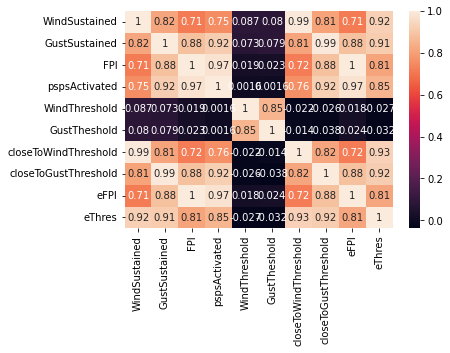

In [38]:
corrMatrix = fire_df_prep.corr()
sn.heatmap(corrMatrix, annot=True)
plt.rcParams["figure.figsize"] = (15, 12)
plt.rcParams["figure.dpi"] = 40
plt.show()

# Number of Incidents vs Reason Graph

Text(0.5, 0, 'Reason')

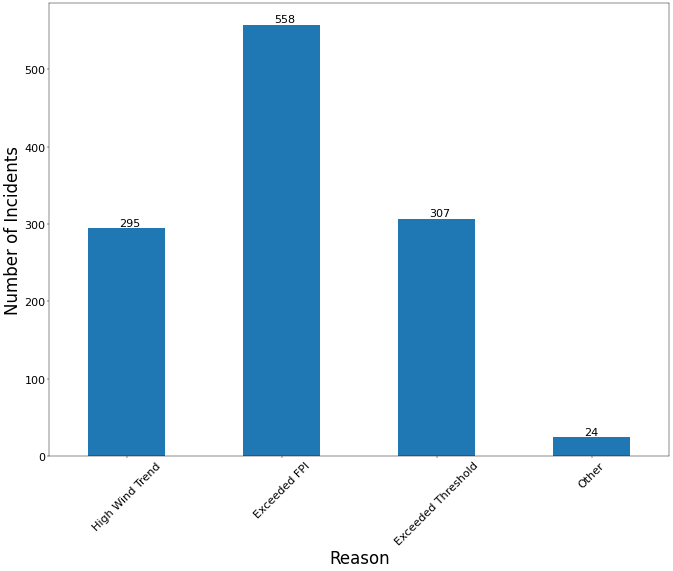

In [85]:
rsns = fire_df_prep[fire_df_prep["Reasons"] != 0]["Reasons"].to_list()

dct = defaultdict(int)
def cnt_rsn(x):
    for i in x.split("-"): dct[i.strip()]+=1

for i in rsns: cnt_rsn(i)

rsns = pd.DataFrame.from_dict(dict(dct), orient='index').reset_index()
rsns.columns = ['Reason', 'Count']
rsns = rsns[rsns["Count"] > 10].append({'Reason': 'Other','Count': sum(rsns[rsns["Count"] <= 10]["Count"].to_list())},
                             ignore_index = True)

ax = rsns.plot(kind='bar',figsize=(20, 15),legend=None)
ax.set_xticklabels(rsns['Reason'], rotation=45, size = 20)
plt.yticks(fontsize=20)
xlocs = [0, 1, 2, 3, 4]
for i, v in enumerate(rsns['Count']):
    plt.text(xlocs[i]-0.05, v + 3, str(v), size = 20)
plt.ylabel('Number of Incidents', size = 30)
plt.xlabel('Reason', size = 30)

# Top 25 Circuits vs Number of Incidents Graph

Text(0.5, 0, 'Top 25 Circuits')

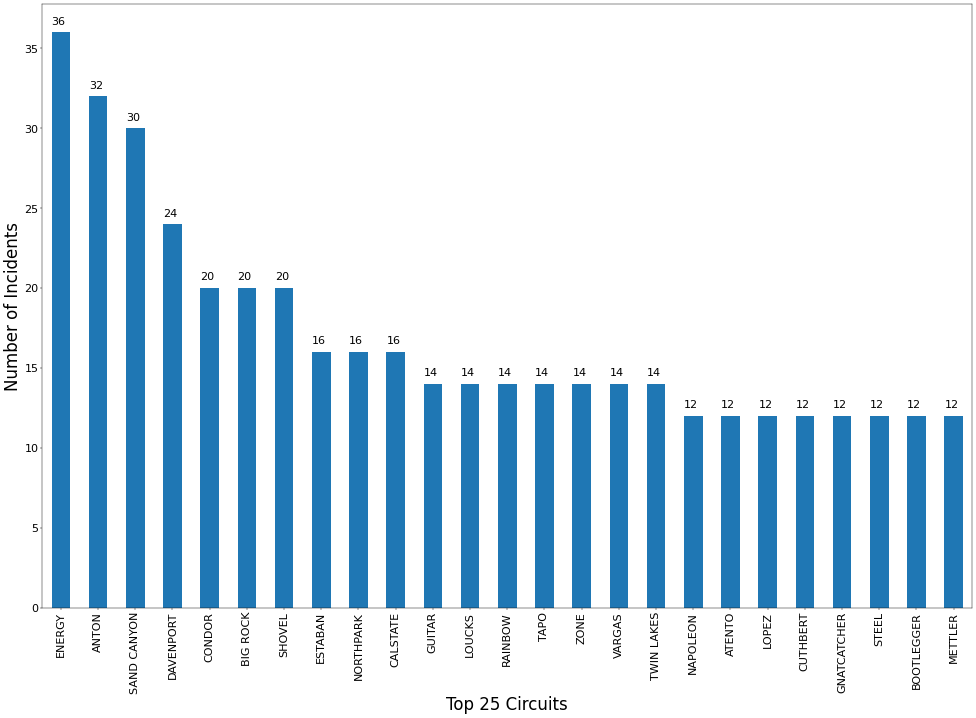

In [148]:
top_vl = 25

circuit = fire_df_prep.groupby(['Circuit']).size().reset_index(name='Count')[::-1]
circuit = circuit.sort_values('Count', ascending=False).reset_index(drop= True).head(top_vl)


ax = circuit.plot(kind='bar',figsize=(30, 20),legend=None)
ax.set_xticklabels(circuit['Circuit'], rotation=90, size = 20)
plt.yticks(fontsize=20)
xlocs = [i for i in range(top_vl)]

for i, v in enumerate(circuit['Count']):
    plt.text(xlocs[i]-0.25, v +0.5, str(v), size = 20)
plt.ylabel('Number of Incidents', size = 30)
plt.xlabel(f'Top {top_vl} Circuits', size = 30)

In [149]:
X = fire_df_prep[x_columns]
y = fire_df_prep['pspsActivated'].values
X.head()

,WindSustained,GustSustained,FPI,closeToWindThreshold,closeToGustThreshold,eFPI,eThres
0,12.2,18.6,3.72,39.35,40.43,0.31,0.40
1,9.1,21.0,4.20,29.35,45.65,0.35,0.46
2,11.9,20.9,4.18,38.39,45.43,0.35,0.45
3,26.0,43.3,14.36,83.87,94.13,1.20,0.94
4,41.2,56.3,12.50,132.90,122.39,1.04,1.33


## Model Selection and train model

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)
X_train=X_train.astype('int')
X_test=X_test.astype('int')
y_train=y_train.astype('int')
y_test=y_test.astype('int')


print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (861, 7) (861,)
Test set: (287, 7) (287,)


## Accuracy Function

In [170]:
def accuracyy_chk(y_test, yhat):
    lst = []
    try: lst+=[round(metrics.accuracy_score(y_test, yhat), 2)]
    except: lst+=[None]
        
    try: lst+=[round(f1_score(y_test, yhat, average='weighted'), 2)]
    except: lst+=[None]
        
    try: lst+=[round(jaccard_score(y_test, yhat, average='weighted'), 2)]
    except: lst+=[None]
        
    try: lst+=[round(evs(y_test, yhat), 2)]
    except: lst+=[None]
        
    try: lst+=[round(r2(y_test, yhat), 2)]
    except: lst+=[None]
        
    try: lst+=[round(metrics.mean_absolute_error(y_test, yhat),2)]
    except: lst+=[None]
        
    try: lst+=[round(metrics.mean_squared_error(y_test, yhat),2)]
    except: lst+=[None]
        
    try: lst+=[round(np.sqrt(metrics.mean_squared_error(y_test, yhat)),2)]
    except: lst+=[None]
        
    try: lst+=[round(metrics.explained_variance_score(y_test, yhat),2)]
    except: lst+=[None]
    
    return lst

# K Nearest Neighbor(KNN)

In [165]:
Ks = 15
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    kNN_model = KNeighborsClassifier(n_neighbors=n).fit(X_train,y_train)
    yhat = kNN_model.predict(X_test)
    mean_acc[n-1]=np.mean(yhat==y_test)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.99651568, 0.98606272, 0.98606272, 0.98606272, 0.98606272,
       0.98606272, 0.98606272, 0.98606272, 0.98606272, 0.98606272,
       0.98606272, 0.98606272, 0.98606272, 0.98606272])

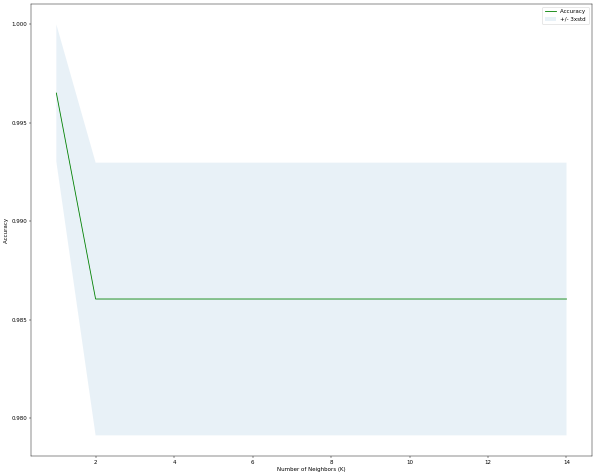

The best accuracy was with 0.9965156794425087 with k= 1


In [167]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)

In [168]:
k = mean_acc.argmax()+1
kNN_model = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
yhat = kNN_model.predict(X_test)

In [172]:
acc_knn = accuracyy_chk(y_test, yhat)

# <h1>Support Vector Machine</h1>

In [173]:
SVM_model = svm.SVC(kernel='rbf')
SVM_model.fit(X_train, y_train)
yhat = SVM_model.predict(X_test)

In [174]:
acc_svm = accuracyy_chk(y_test, yhat)

# Logistic Regression

In [175]:
LR_model = LogisticRegression(C=0.01).fit(X_train,y_train)
yhat = LR_model.predict(X_test)

In [176]:
acc_logr = accuracyy_chk(y_test, yhat)

# Linear Regression

In [177]:
LRRR_model = LinearRegression()
LRRR_model.fit(X_train,y_train)
yhat = LRRR_model.predict(X_test)

In [178]:
acc_lnr = accuracyy_chk(y_test, yhat)

# Random Forest Regressor

In [179]:
X = preprocessing.StandardScaler().fit(X).transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
X_train=X_train.astype('int')
X_test=X_test.astype('int')
y_train=y_train.astype('int')
y_test=y_test.astype('int')


rfr_model = RandomForestRegressor(n_estimators=20, random_state=0)
rfr_model.fit(X_train,y_train)
yhat = rfr_model.predict(X_test)

In [180]:
acc_rfr = accuracyy_chk(y_test, yhat)

# Accuracy Comparison

In [183]:
pd.DataFrame(
{'Algorithm':['KNN', 'SVM', 'Logistic Regression', 'Linear Regression', 'Random Forest Regressor'],
'Explained Variance Score':[acc_knn[3], acc_svm[3], acc_logr[3], acc_lnr[3], acc_rfr[3]],
'R2-score':[acc_knn[4], acc_svm[4], acc_logr[4], acc_lnr[4], acc_rfr[4]],
'Mean Absolute Error':[acc_knn[5], acc_svm[5], acc_logr[5], acc_lnr[5], acc_rfr[5]],
'Mean Squared Error':[acc_knn[6], acc_svm[6], acc_logr[6], acc_lnr[6], acc_rfr[6]],
'Root Mean Squared Error':[acc_knn[7], acc_svm[7], acc_logr[7], acc_lnr[7], acc_rfr[7]]
})


,Algorithm,Explained Variance Score,R2-score,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error
0,KNN,0.99,0.99,0.00,0.00,0.06
1,SVM,0.95,0.94,0.01,0.01,0.12
2,Logistic Regression,0.96,0.96,0.01,0.01,0.10
3,Linear Regression,0.97,0.97,0.04,0.01,0.09
4,Random Forest Regressor,0.73,0.73,0.12,0.07,0.26


# Saving models to pickle file

In [25]:
lst = [kNN_model, SVM_model, LR_model, LRRR_model, rfr_model]
modl_nmz = ["kNN", "SVM", "LogR", "LinearR", "RandomFR"]

for i, modll in enumerate(lst):
    joblib.dump(modll, (f"Models/{modl_nmz[i]}.pkl"))

# Using Model to predict the values


In [26]:
test_df_raw = prepare_test_data(pd.read_csv("CSV/test_data1.csv"))

test_df = test_df_raw[x_columns]
test_df_rnd = preprocessing.StandardScaler().fit(test_df).transform(test_df)


for i, modll in enumerate(lst):
    data_test_us = test_df
    if(i==4): data_test_us = test_df_rnd
    y_predctd = modll.predict(data_test_us)
    
    y_predctd = pd.DataFrame(y_predctd, columns = ["PSPS_Activation_probability%"])
    ds = pd.concat([test_df_raw, y_predctd],axis=1)
    ds["PSPS_Activation_probability%"] = round(ds["PSPS_Activation_probability%"] * 100, 2)
    ds.to_csv(f"Report/Result_{modl_nmz[i]}.csv")

# Data Visualization of Predicted Values

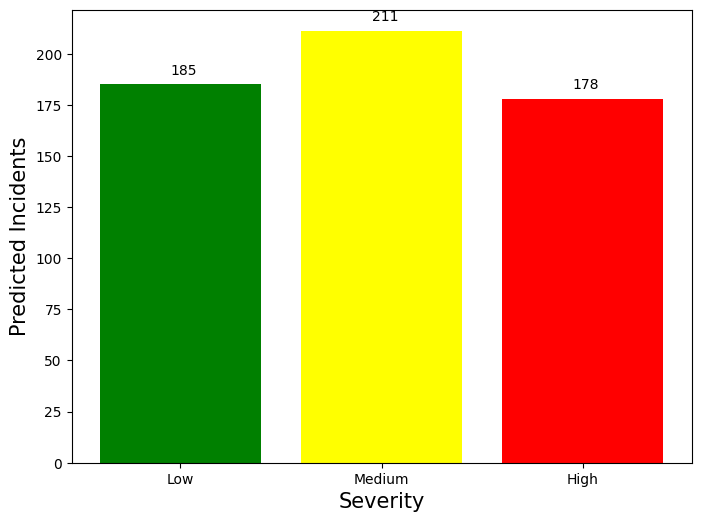

In [192]:
fire_grp = pd.read_csv(f"Report/Result_LinearR.csv")

def fnc(x):
    if (x>85): return "C"
    elif (85>=x>60): return "B"
    else: return "A"

fire_grp["pspsGRP"] = fire_grp["PSPS_Activation_probability%"].apply(lambda x: fnc(x))
month = fire_grp.groupby(['pspsGRP']).size().reset_index(name='count')[::-1].sort_values('pspsGRP')
labels = ["Low", "Medium", "High"]
values = month['count'].tolist()
if(len(values)<3):
    values += [0]*(3-len(values))

plt.figure(figsize=(8, 6), dpi=100)
plt.ylabel('Predicted Incidents', size = 15)
plt.xlabel('Severity', size = 15)
plt.bar(labels, values, color=['green', 'yellow', 'red'])
xlocs = [0, 1, 2]
for i, v in enumerate(month['count']):
    plt.text(xlocs[i]-0.05, v + 5, str(v))

plt.show()